In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from numpy import polyfit

MU = 2.0
SIGMA = 0.5

In [2]:
#Variables definition
Omega_r = None #Rotor rotational speed
Omega_g = None #Generator rotational speed
dOmega_r = None #Rotor rotational acceleration
dOmega_g = None #Generator rotational acceleration
Theta = None #Torsional displacement
dTheta = None #Torsional speed
Rho_v = 1.225 #Air density
v_t = None #Wind speed
v_bar = 10 #Average wind
vTil_L = 5 #Minimum wind turbulence intensity
vTil_U = 0.2 #Maximum wind turbulence intensity
R_r = 57.5 #Rotor radius
A_r = None #Rotor area
Rho_r = None #XXXXX
B_dt = 755.49 #D_exp_exp_exp_exp_exp_exp_exp_expamping of the drivetrain
K_dt = 2.7*(1e9) #Stiness of the drivetrain
J_r = 55*(1e6) #Inertia of the rotor
J_g = 55*(1e6) #Inertia of the drivetrain
C_pMax = 0.486 #Max. power coefficient
Lambda_opt = 7.6 #Optimal tip-speed ratio
Phi_opt = 0 #Optimal pitch angle 0 deg

In [7]:
class beta_estimator:
    def __init__(self):
        self.k = 1
        self.mu = 2
        self.sigma = 0.5
        self.num_trajectories = 50
        self.threshold = 500
        self.dt_lin = 1
        self.dt_exp = 0.1
        self.D_lin = [np.array([1e-16]) for i in range(self.num_trajectories)]
        self.D_exp = [np.array([1]) for i in range(self.num_trajectories)]
        self.D_M = np.array([0])
        self.b0s = [np.array([0]) for i in range(self.num_trajectories)]
        self.b1s = [np.array([0]) for i in range(self.num_trajectories)]
        self.b0_bar = np.array([0])
        self.b1_bar = np.array([0])

    def beta_calc(self, f_w=1):
        np.random.seed(self.k)
        gamma = np.random.normal(self.mu, self.sigma)
        for i in range(self.num_trajectories):
            np.random.seed(i)
            eta = np.random.normal(self.mu, self.sigma)
            beta_0 = gamma*f_w + eta
            self.b0s[i] = np.append(self.b0s[i],beta_0)
            D_now = self.D_lin[i][-1] + beta_0*self.dt_lin
            self.D_lin[i] = np.append(self.D_lin[i], D_now)

        for i in range(self.num_trajectories):
            np.random.seed(i)
            eta = np.random.normal(self.mu, self.sigma)
            beta_1 = gamma*f_w + eta
            self.b1s[i] = np.append(self.b1s[i],beta_1)
            D_now = self.D_exp[i][-1] + self.D_exp[i][-1] * beta_1 * self.dt_exp
            self.D_exp[i] = np.append(self.D_exp[i], D_now)
            
    def D_hat(self):
        D_lin = np.array(self.D_lin).T
        D_exp = np.array(self.D_exp).T
        sum = D_lin + D_exp
        D = np.array([np.mean(sum[i]) for i in range(len(sum))])
        return D


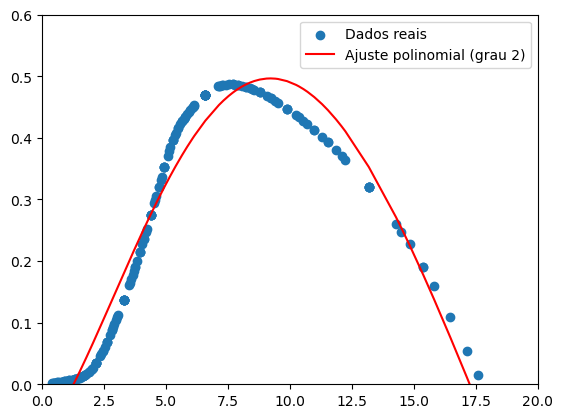

In [28]:
path = 'CpVersusTSR&Pitch_WT_Perf_V1.csv'
df = pd.read_csv(path,header=None)
x = df.iloc[:,0].values
y = [df.iloc[:,i+6].values for i in range(6)]
ymax = [np.max(df.iloc[:,i+6].values) for i in range(6)]
x_max = [np.where(df.iloc[:,i+6].values==np.max(df.iloc[:,i+6].values)) for i in range(6)]

coeffs = polyfit(x, y[0], 5)
def Cp_calc(x):
    return coeffs[0] * x**5 + coeffs[1] * x**4 + coeffs[2] * x**3 + coeffs[3] * x**2 + coeffs[4] * x**1 + coeffs[5] * x**0 

plt.scatter(x, y[0], label='Dados reais')
plt.plot(x, Cp_calc(x), color='r', label='Ajuste polinomial (grau 2)')
plt.xlim(0, 20)
plt.ylim(0, 0.6)
plt.legend()
plt.show()

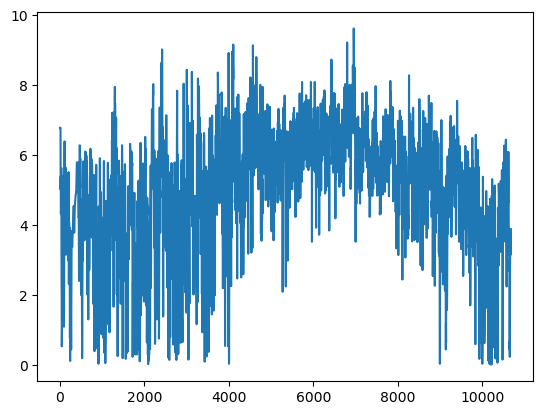

In [67]:
path  = 'data_tibau.csv'
df = pd.read_csv(path, header=None)
v = df.iloc[:,1].values
plt.plot(v)

In [68]:
class Dynamics:
    def __init__(self):
        self.Bdt = 755.49
        self.Kdt = 2.7*1e9
        self.Jg = 55*1e6
        self.Jr = 55*1e6    
        self.wr = 1
        self.wg = 1
        self.ot = 0
        self.RHOv = 1.225 #Air density
        self.Ar = np.pi * 57.5**2 #Rotor area
        self.Rr = 57.5 
        self.Cp_Max = 0.486
        self.lambda_opt = 7.6
        self.A=np.array([[-self.Bdt/self.Jr, self.Bdt/self.Jr, -self.Kdt/self.Jr],
                         [self.Bdt/self.Jg, -self.Bdt/self.Jg, self.Kdt/self.Jg],
                         [1, -1, 0]])
        self.B = np.array([[1/self.Jr, 0],
                           [0, -1/self.Jg],
                           [0, 0]])
        
    def Lambda(self,v):
        return self.wr*self.Rr/v
    
    def Cp(self,v):
        print('lamb',self.Lambda(v))
        return (self.Cp_Max*self.Lambda(v)**3)/(self.lambda_opt**3)
    
    def Kmppt(self):
        return 0.5*self.RHOv*self.Ar*(self.Rr**3)*self.Cp_Max/(self.lambda_opt**3)

    def dot_states(self,v):

        tau_r = 0.5*self.RHOv*self.Ar*self.Cp(v)*(v**3)/(self.wr)
        tau_g = self.Kmppt()*(self.wg**2)
        input_ = np.array([tau_r, tau_g]).reshape(-1,1)
        states = np.array([self.wr, self.wg, self.ot]).reshape(-1,1)
        d_states = self.A@states + self.B@input_

        print('antes:', states)

        d_wr = d_states[0]
        d_wg = d_states[1]
        d_ot = d_states[2]

        self.wr = self.wr + d_wr
        self.wg = self.wg + d_wg
        self.ot = self.ot + d_ot
        
        states = np.array([self.wr, self.wg, self.ot]).reshape(-1,1)
        print('depois:', states)

        return states

d = Dynamics()

In [ ]:
vec = []
for i in range(len(v)):
    vec.append(d.dot_states(v[i]))

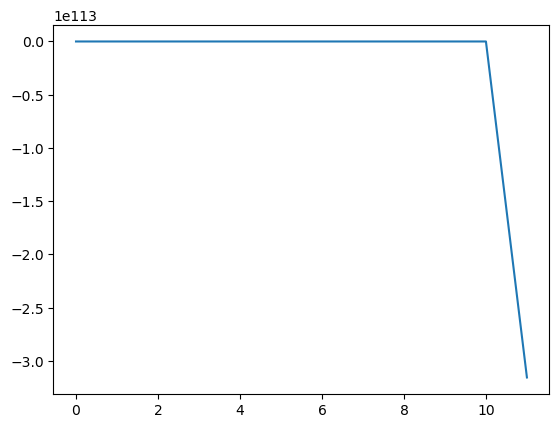

In [77]:
plt.plot(np.array(vec).T[0][1])